# Quantum 2x2 Games

This notebook has been developed in order to formulate and analyze numerically the quantum version of two canonical Game Theory problems: Prisoners' Dilemma and (an anticipation to the) Battle of Sexes, studying all the possible quantum pure strategies available to the players.

In [1]:
import numpy as np
import cmath
from scipy import linalg
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm
import seaborn as sns
import warnings
import matplotlib.patches as mpatches


pd.set_option('display.max_rows', 10)
sns.set_style("ticks")

The action space of a quantum 2x2 game is SU(2), i.e. the Hilbert space of unitary, trace-preserving 2x2 matrices.

A generic matrix in SU(2) can be written as a function of 2 parameters: <br>

$$
\hat{U}(\theta,\phi) = \begin{pmatrix}
e^{i\phi}\cos\theta/2 & \sin\theta/2 \\ -\sin\theta/2 & e^{-i\phi}\cos\theta/2
\end{pmatrix} \quad \theta\in[0,\pi], \phi\in[0,\frac{\pi}{2}] 
$$

Also the original pure strategies for cooperating, C, and defecting, D, can be written in this way:

$$
\hat{C} = \hat{U}(0,0) = \begin{pmatrix}1&0\\0&1\end{pmatrix} \qquad
\hat{D} = \hat{U}(\pi,0) = \begin{pmatrix}0&1\\-1&0\end{pmatrix}
$$

Usually, in these kind of games, each player has access to two pure strategies, C and D, and to the corresponding payoff bymatrix:

$$
\begin{pmatrix}
P_{CC,A},P_{CC,B} & P_{CD,A},P_{CD,B} \\ P_{DC,A},P_{DC,B} & P_{DD,A},P_{DD,B} \\
\end{pmatrix}
$$

The states of the (quantum) system are defined, as said, in SU(2), and are expressed as column vectors with four elements, written in the basis given by {|CC>, |CD>, |DC>, |DD>}, i.e. the computational basis (for example, |CC> corresponds to the vector (1,0,0,0), and so on).

In order to construct an effective quantum game, we need to provide also some kind of entanglement between the various states, and this will be possible introducing an operator that depends on a "entanglement measure"

$$
\hat{J} = \exp\left(-i\gamma\hat{D}\otimes\hat{D}/2\right) \qquad \gamma\in[0,\frac{\pi}{2}]
$$

such that the final state of the system, after the application of the actions chosen by the players, but before the effective measure of the qubits, will be given by:

$$
|\psi_f> = \hat{J}^\dagger\left(\hat{U}_A\otimes\hat{U}_B\right)\hat{J}|CC>
$$

In the end, since the only way to find the best set of strategies to follow is to check the payoff, the formula to compute the expected utility for player i is:

$$
<i> = P_{CC,i}\cdot|<CC|\psi_f>|^2 + P_{CD,i}\cdot|<CD|\psi_f>|^2 + P_{DC,i}\cdot|<DC|\psi_f>|^2 + P_{DD,i}\cdot|<DD|\psi_f>|^2
$$

With the purpose of analyzing numerically the problem, we are going to write a class that contains all the necessary attributes and functions for a complete simulation.

In [2]:
class Quantum2x2Game:
    
    def __init__(self, payoff_matrix, gamma=0, grid_step=np.pi/10, accuracy=1E-2):
        """ In the constructor we initialize:
        * the bimatrix of the payoffs
        * the two main quantum strategies of collaboration and defection in 2x2 games
        * the entanglement measure of the game
        * the default values for the grid of parameters, that will depend on the grid_step parameter
        * the final grid of parameters
        Note: the problem will be discretized, and so the thinner is the grid the more accurate will 
        be the final solution, but the cost is an increased computational time. """
        self.payoff_matrix = payoff_matrix
        self.C = self.quantum_strategy(0, 0)         # Strategy of cooperation
        self.D = self.quantum_strategy(np.pi, 0)     # Strategy of defection
        self.gamma = gamma                           # Entanglement measure
        
        # Default values for the grid of parameters
        self.thetaA = np.arange(0, np.pi+grid_step, grid_step)
        self.phiA   = np.arange(0, np.pi/2+grid_step/2, grid_step/2)
        self.thetaB = np.arange(0, np.pi+grid_step, grid_step)
        self.phiB   = np.arange(0, np.pi/2+grid_step/2, grid_step/2)
        self.grid = None
        self.NE   = None
        self.guaranteed_payoffs = {"A" : None, "B" : None}
        self.accuracy = accuracy
        return
    
    def update_parameters(self, theta=None, phi=None, player=None):
        """ Redefine the default values for the grid of parameters; for example if you want to force a player
        to select a certain subset of strategies. The parameters to this function has to be submitted as 
        lists. """
        if player == "A":
            if theta is not None: self.thetaA = theta
            if phi   is not None: self.phiA = phi
        if player == "B":
            if theta is not None: self.thetaB = theta
            if phi is not None: self.phiB = phi
        return
        
    def quantum_strategy(self, theta, phi):
        """ This function returns a matrix in SU(2), corresponding to a quantum pure strategy, given the 
        two necessary parameters. """
        qs = np.zeros([2,2], dtype=complex)
        qs[0,0] = cmath.exp(1j*phi)*np.cos(theta/2)
        qs[0,1] = np.sin(theta/2)
        qs[1,0] = -np.sin(theta/2)
        qs[1,1] = cmath.exp(-1j*phi)*np.cos(theta/2)
        return qs
    
    def compute_final_state( self, strategyA, strategyB ):
        """ This function takes in input a couple of quantum strategies, so matrices in SU(2), and return
        the density matrix of the final state of the system after their application. The parameter gamma
        will reproduce the entanglement between the states of the two players via a proper operator J. """
        J = linalg.expm(-1j*self.gamma*np.kron(self.D,self.D)/2)      # Construct matrix J
        J1 = J.conjugate().transpose()                                # J^+ is just J's adjoint
        UAB = np.kron(strategyA, strategyB)                           # UA x UB is the kronecker product between 
                                                                      # the two quantum strategies
        # Apply the operators one by one
        psi_f = np.matmul(J,np.array([1,0,0,0]))
        psi_f = np.matmul(UAB, psi_f)
        psi_f = np.matmul(J1, psi_f)      
        return psi_f
    
    def expected_payoffs( self, state ):
        """ Given a state represented by a 2x2 density matrix, like the form returned by the function 
        compute_final_state(), it returns a list containing the expected payoffs calculated for both 
        players in that state. """
        payoffA, payoffB = 0, 0
        for i in range(2):
            for j in range(2):
                payoffA += self.payoff_matrix['A'][i,j]*(abs(state[2*i+j])**2)
                payoffB += self.payoff_matrix['B'][i,j]*(abs(state[2*i+j])**2)
        return [payoffA, payoffB]
    
    def compute_payoff_grid( self ):
        """ This function receive in input four vectors, representing our discretized grid of parameters
        describing the strategies chosen by our players. The output is a Pandas DataFrame containing all the 
        possible combinations of such parameters, together with the final payoffs associated in each case. """ 
        if self.grid is not None:
            return self.grid
        
        size = len(self.thetaA)*len(self.phiA)*len(self.thetaB)*len(self.phiB)
        grid = np.zeros(shape=(size,6))
        pbar = tqdm(total = size)
        s = 0

        for i in self.thetaA:
            for j in self.phiA:
                for k in self.thetaB:
                    for l in self.phiB:
                        sA = self.quantum_strategy(i, j)
                        sB = self.quantum_strategy(k, l)
                        fs = self.compute_final_state(sA, sB)  
                        utility = self.expected_payoffs(fs)
                        grid[s] = [i, j, k, l, utility[0], utility[1]]
                        s += 1
                        pbar.update(1)
                        
        # Construct a pandas DataFrame with the grid
        df = pd.DataFrame(grid, columns=["thetaA","phiA","thetaB","phiB","utilityA", "utilityB"])
        self.grid = df
        return df
    
    def Is_Best_Response( self, row, player ):
        ''' Return true if strategy A/B is a best response to B/A '''
        if player == "A": opponent = "B"
        elif player == "B": opponent = "A"        
    
        util_p = "utility" + player
        th_o = "theta" + opponent
        ph_o = "phi" + opponent
        max_util_p = self.grid[(self.grid[th_o]==row[th_o]) & (self.grid[ph_o]==row[ph_o])].max()[util_p]
        
        # Return True if strategy of player is a best response to the strategy of the opponent (accuracy = 1E-2)
        if abs(row[util_p] - max_util_p)<self.accuracy: return True
        else: return False
        
    def compute_Nash_Equilibrium( self ):
        """ This function takes the grid of parameters, compute it eventually, and add two columns, that
        basically tell if the startegy of players A and B in each row, are a best response one of the other. 
        Then, since the Nash equilibria are by definition, pair of strategies that are mutual best responses,
        a subset of rows, satisfying this condition, is extracted and returned. """
        if self.NE is not None: return self.NE
        
        # Construct the payoff grid
        if self.grid is None: 
            print("Constructing the complete grid of payoffs...")
            self.compute_payoff_grid()
            
        # Initialize two new empty columns
        self.grid["Best_responses_A"] = None
        self.grid["Best_responses_B"] = None
        
        # Collect all the best responses of player A to any strategy of B and viceversa
        print("Computing the best responses for the players...")
        for index, row in tqdm(self.grid.iterrows(),total=len(self.grid)):
            self.grid.loc[index, "Best_responses_A"] = self.Is_Best_Response(row, "A")
            self.grid.loc[index, "Best_responses_B"] = self.Is_Best_Response(row, "B")
        
        # The joint strategies that are NE are simoultanoeus best responses
        self.NE = self.grid[self.grid["Best_responses_A"] & self.grid["Best_responses_B"]]
        
        return self.NE
    
    def Is_Pareto_Optimal( self, joint_strategy_idx ):
        """ This function checks if a strategy, given its position in the grid, is Pareto Optimal, i.e. if
        there is no other strategy that could increase the payoffs for both players. """
        util_A = self.grid.loc[joint_strategy_idx, "utilityA"]
        util_B = self.grid.loc[joint_strategy_idx, "utilityB"]
        
        pareto_opt = self.grid[(self.grid["utilityA"]>util_A) & (self.grid["utilityB"]>util_B)]
    
        if pareto_opt.empty: 
            print("The strategy is Pareto optimal!")
            return 
        else:
            print("The strategy is not Pareto optimal! ")
            print("Better alternatives:")
            display(pareto_opt)
        return 
    
    def compute_guaranteed_payoffs( self, player ):
        """ This function compute the minima guaranteed payoffs for one of the player, i.e. the minima utility
        value over all the possibilities, for all the possible strategies of the opponent. """
        if self.guaranteed_payoffs[player] is not None: return self.guaranteed_payoffs[player]
        if self.grid is None: self.compute_payoff_grid()
        
        s = 0
        if player == "A":
            theta = self.thetaA
            phi = self.phiA
        elif player == "B":
            theta = self.thetaB
            phi = self.phiB
        
        pbar = tqdm(total = len(theta)*len(phi))
        min_utils = np.zeros(shape=(len(theta)*len(phi), 3))
        for t in theta:
                for p in phi:
                    # Take the minimum payoff achievable if player A/B plays U(t, p)
                    min_u = self.grid[(self.grid["theta"+player]==t) & 
                                       (self.grid["phi"+player]==p)].min()["utility"+player]
                    min_utils[s] = [t, p, min_u]
                    s+=1
                    pbar.update(1)
        
        self.guaranteed_payoffs[player] = pd.DataFrame(min_utils, columns=("theta", "phi", "utility"))
        
        return self.guaranteed_payoffs[player]            

Just to check the correctness of our code, we can rely on the fact that selecting $\gamma=0$ we should obtain the original classical game! <br>
So, if for example, we ask the two players to choose the joint strategy {DC} (with a dummy payoff matrix), then as final state we should get |DC> in the computational basis, that is (0,0,1,0).

In [3]:
warnings.filterwarnings('ignore')
dummy_payoffs = {'A' : np.array([[3,0],[5,1]]), 'B' : np.array([[3,5],[0,1]]) }
dummy_game = Quantum2x2Game( payoff_matrix=dummy_payoffs )
dummy_game.compute_final_state( strategyA=dummy_game.D, strategyB=dummy_game.C ).astype(int)

array([ 0,  0, -1,  0])

Note: the -  sign in the coefficient is irrelevant because what matters is its square module, i.e. $|-1|^2$, that represents the probability of finding the system in the state CD.

So everything seems working fine!

Regarding the possibility of considering quantum mixed strategies, the application appears quite challenging: in the classical case a mixed strategy was a convex combination of pure strategies, so in a 2x2 game was something like $p\hat{A}+(1-p)\hat{B}$. But in a quantum world, the space of pure strategies is continuous, so, in order to properly build a mixed strategy, one need to consider a probability distribution, instead of just a parameter $p$, as:
$$
\int\hat{U}(\theta,\phi)p(\theta,\phi)d\theta d\phi
$$

But the number of probability distributions that we can construct over the space spanned by the parameters ($\theta,\phi$) is basically infinite.

For this reason, in the sequent analysis we will check only pure strategies, and the consequent equilibria.

# Quantum Prisoners' Dilemma

The first problem that we are going to simulate as a quantum system is the traditional Prisoners' Dilemma.

In [4]:
# Specify the payoff matrix
payoff_matrix_pd = {'A' : np.array([[3,0],[5,1]]), 'B' : np.array([[3,5],[0,1]]) }

It may be interesting, now, to analyze the different payoffs of player A in particular configurations. Then the game, at least for the moment, is symmetric, and so we are allowed to draw the same conclusions also for player B.

#### Separable case: $\gamma=0$

In [5]:
# Construct the game
PrisonersDilemma_g0 = Quantum2x2Game( payoff_matrix=payoff_matrix_pd, gamma=0 )

The dimensionality of the problem is 5, and so is not so easy to plot a "utility function" directly. So, in order to find the maximum values we proceed numerically, showing only the most significant plots.

The best way to find numerically the Nash Equilibrium of the game is applying the definition, and looking for the joint strategy, i.e. a set $\{\theta_A, \phi_A, \theta_B, \phi_B\}$ that is a best response for both players to any other possible choice of the opponent. For this reason, in the class we have an apposite function.

In [6]:
NE_qpd = PrisonersDilemma_g0.compute_Nash_Equilibrium()

Constructing the complete grid of payoffs...


  0%|          | 0/14641 [00:00<?, ?it/s]

Computing the best responses for the players...


  0%|          | 0/14641 [00:00<?, ?it/s]

In [7]:
display(NE_qpd)

,thetaA,phiA,thetaB,phiB,utilityA,utilityB,Best_responses_A,Best_responses_B
13420,3.141593,0.000000,3.141593,0.000000,1.0,1.0,True,True
13421,3.141593,0.000000,3.141593,0.157080,1.0,1.0,True,True
13422,3.141593,0.000000,3.141593,0.314159,1.0,1.0,True,True
13423,3.141593,0.000000,3.141593,0.471239,1.0,1.0,True,True
13424,3.141593,0.000000,3.141593,0.628319,1.0,1.0,True,True
...,...,...,...,...,...,...,...,...
14636,3.141593,1.570796,3.141593,0.942478,1.0,1.0,True,True
14637,3.141593,1.570796,3.141593,1.099557,1.0,1.0,True,True
14638,3.141593,1.570796,3.141593,1.256637,1.0,1.0,True,True
14639,3.141593,1.570796,3.141593,1.413717,1.0,1.0,True,True


Now we can show all the joint strategies that are Nash equilibria for $\gamma=0$.

Becuase of the limited numerical precision, is better now to look directly in the dataframe containing all the Nash equilibria, to avoid errors. <br>
The first thing we can notice is the fact that the parameters $\phi_A$ and $\phi_B$ seems to be ininfluent on the final payoff: the reason is that since $\gamma=0$, all the probabilities and the states of the two players are separable, and so all these complex phases vanishes when multiplying first by $\hat{J}$ and then by $\hat{J^\dagger}$. Another point of view can be found looking at the values of $\theta_A$ and $\theta_B$, that are all equal to $\pi$; then, remembering the form of the generic SU(2) strategy, all the contributes of $\phi$ vanishes when setting $\theta=\pi$. <br>
So, we are able to finally state that for $\gamma=0$, all the nash equilibrium strategies are of the type $\{\hat{U}(\pi,\phi_A),\hat{U}(\pi,\phi_B)\}$ and the corresponding utility values are $[1,1]$. <br>
Final thing to recall: $\hat{U}(\pi,\phi)$ is nothing but the old pure strategy of defection $\hat{D}$.

We can have further confirmations to this making additional analysis:

* we can give a look at the payoff of each player as functions of the parameters $\theta$ (since $\phi$, as we have seen, has no importance at the equilibrium);

In [8]:
grid_gamma0 = PrisonersDilemma_g0.compute_payoff_grid()

In [9]:
# Take the parameter used 
thetaA = PrisonersDilemma_g0.thetaA
phiA   = PrisonersDilemma_g0.phiA
thetaB = PrisonersDilemma_g0.thetaB
phiB   = PrisonersDilemma_g0.phiB

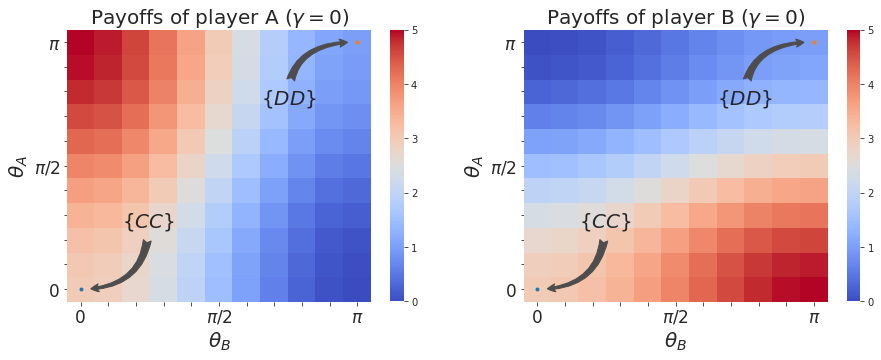

In [10]:
# Plot the results as a heatmap
fig, ax = plt.subplots(1,2,figsize=(15,5))
grid_gamma0_pivotA = grid_gamma0[(grid_gamma0["phiA"]==0) & (grid_gamma0["phiB"]==0)].pivot("thetaA", "thetaB", "utilityA")
grid_gamma0_pivotB = grid_gamma0[(grid_gamma0["phiA"]==0) & (grid_gamma0["phiB"]==0)].pivot("thetaA", "thetaB", "utilityB")

ticklabels = ['0'] + ['']*(len(thetaB)//2-1) + [r'$\pi$/2'] + ['']*(len(thetaB)//2-1) + [r'$\pi$']


pAgamma0 = sns.heatmap(grid_gamma0_pivotA, cmap="coolwarm", ax=ax[0])
pAgamma0.set_title(r'Payoffs of player A ($\gamma=0$)', fontsize=20)
pAgamma0.set_ylabel(r'$\theta_A$', fontsize = 20)
pAgamma0.set_xlabel(r'$\theta_B$', fontsize = 20)
pAgamma0.set_xticklabels(ticklabels, size = 17, rotation=0)
pAgamma0.set_yticklabels(ticklabels, size = 17)
pAgamma0.plot(0.5, 0.5, ".")
pAgamma0.annotate(r'$\{CC\}$', xy=(0.5, 0.5), fontsize=20, xytext=(2,3),
                  arrowprops=dict(arrowstyle="fancy", color="0.3", shrinkA=5, shrinkB=10, 
                                connectionstyle="angle3,angleA=90,angleB=0"))
pAgamma0.plot(10.5, 10.5, ".")
pAgamma0.annotate(r'$\{DD\}$', xy=(10.5, 10.5), fontsize=20, xytext=(7,8),
                  arrowprops=dict(arrowstyle="fancy", color="0.3", shrinkA=5, shrinkB=10, 
                                connectionstyle="angle3,angleA=90,angleB=0"))


pBgamma0 = sns.heatmap(grid_gamma0_pivotB, cmap="coolwarm", ax=ax[1]);
pBgamma0.set_title(r'Payoffs of player B ($\gamma=0$)', fontsize=20)
pBgamma0.set_ylabel(r'$\theta_A$', fontsize = 20)
pBgamma0.set_xlabel(r'$\theta_B$', fontsize = 20)
pBgamma0.set_xticklabels(ticklabels, size = 17, rotation=0)
pBgamma0.set_yticklabels(ticklabels, size = 17)
pBgamma0.plot(0.5, 0.5, ".")
pBgamma0.annotate(r'$\{CC\}$', xy=(0.5, 0.5), fontsize=20, xytext=(2,3),
                  arrowprops=dict(arrowstyle="fancy", color="0.3", shrinkA=5, shrinkB=10, 
                                connectionstyle="angle3,angleA=90,angleB=0"))
pBgamma0.plot(10.5, 10.5, ".")
pBgamma0.annotate(r'$\{DD\}$', xy=(10.5, 10.5), fontsize=20, xytext=(7,8),
                  arrowprops=dict(arrowstyle="fancy", color="0.3", shrinkA=5, shrinkB=10, 
                                connectionstyle="angle3,angleA=90,angleB=0"))

ax[0].invert_yaxis()
ax[1].invert_yaxis()

plt.show()

As expected, if one player goes $\theta\to 0$ and the other goes $\theta\to\pi$ we are in the classical situations of joint strategies {CD} or {DC}, in which the utility is low for one and big for the other one, but this is not a NE. So for $\gamma=0$ the game is basically the same as in the classic world (in some sense we can make a correspondence between quantum strategies with $\theta=\pi$ and classical mixed strategies). If we look at the plots above, the NE strategy is not pareto optimal, and so the "dilemma" still holds.

* or we can instead analyze the minima payoff guaranteed to player A for any of his strategies, and then extending the results to player B by symmetry.

In [11]:
min_payoffs_gamma0_A = PrisonersDilemma_g0.compute_guaranteed_payoffs("A")

  0%|          | 0/121 [00:00<?, ?it/s]

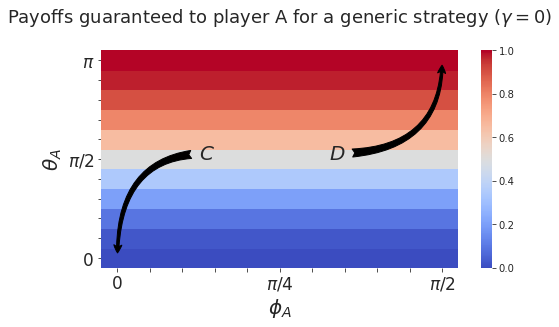

In [12]:
# Plot the results as a heatmap
fig = plt.figure(figsize=(8,4))
min_payoffs_gamma0_A_pivot = min_payoffs_gamma0_A.pivot("theta", "phi", "utility")

xticklabels = ['0'] + ['']*(len(phiA)//2-1) + [r'$\pi$/4'] + ['']*(len(phiA)//2-1) + [r'$\pi/2$']
yticklabels = ['0'] + ['']*(len(thetaA)//2-1) + [r'$\pi$/2'] + ['']*(len(thetaA)//2-1) + [r'$\pi$']

minpAgamma0 = sns.heatmap(min_payoffs_gamma0_A_pivot, cmap="coolwarm")

minpAgamma0.set_xticklabels(xticklabels, size = 17, rotation=0)
minpAgamma0.set_yticklabels(yticklabels, size = 17)
minpAgamma0.set_title(r'Payoffs guaranteed to player A for a generic strategy ($\gamma=0$)', fontsize=18, y=1.1)
minpAgamma0.set_xlabel(r'$\phi_A$', fontsize=20)
minpAgamma0.set_ylabel(r'$\theta_A$', fontsize=20)

minpAgamma0.annotate(r'$C$', xy=(0.5,0.5), fontsize=20, xytext=(3,5.5),
                  arrowprops=dict(arrowstyle="fancy", color="0", shrinkA=5, shrinkB=5,
                                 connectionstyle="angle3,angleA=0,angleB=90"))
minpAgamma0.annotate(r'$D$', xy=(10.5,10.5), fontsize=20, xytext=(7,5.5),
                  arrowprops=dict(arrowstyle="fancy", color="0", shrinkA=5, shrinkB=5,
                                 connectionstyle="angle3,angleA=0,angleB=90"))

plt.gca().invert_yaxis()

Again we get something that we expected: the minimum payoff guaranteed to player A is between 0 (strategy {CD}) and 1 (at the NE). And the same results, for symmetry, hold for player B.

Analogy with classical game:if A decides to play $\hat{D}$ (for simplicity), his payoff is maximized regardless of the strategy chosen by player B. <br>
And since, as we said, the game is symmetric, we have found an equilibrium, i.e. $\hat{D}\otimes\hat{D}$, in dominant strategies.

Let's see if this NE, $\{\hat{D},\hat{D}\}$ is at least Pareto optimal:

In [13]:
# DD is the 13420th row in the grid
PrisonersDilemma_g0.Is_Pareto_Optimal(13420)

The strategy is not Pareto optimal! 
Better alternatives:


,thetaA,phiA,thetaB,phiB,utilityA,utilityB,Best_responses_A,Best_responses_B
0,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,False,False
1,0.000000,0.000000,0.000000,0.157080,3.000000,3.000000,False,False
2,0.000000,0.000000,0.000000,0.314159,3.000000,3.000000,False,False
3,0.000000,0.000000,0.000000,0.471239,3.000000,3.000000,False,False
4,0.000000,0.000000,0.000000,0.628319,3.000000,3.000000,False,False
...,...,...,...,...,...,...,...,...
13294,2.827433,1.570796,2.827433,0.942478,1.072816,1.072816,False,False
13295,2.827433,1.570796,2.827433,1.099557,1.072816,1.072816,False,False
13296,2.827433,1.570796,2.827433,1.256637,1.072816,1.072816,False,False
13297,2.827433,1.570796,2.827433,1.413717,1.072816,1.072816,False,False


It isn't, as in the classical game: the only strategy that is Pareto optimal is the mutual cooperation, that is not NE.

#### Maximally entangled case: $\gamma=\pi/2$

Then, using the same approach, we can analyze also the case in which the two players' states are maximally entangled. <br>
Let's fix $\gamma=\pi/2$.

In [14]:
# Construct the game
PrisonersDilemma_gmax = Quantum2x2Game( payoff_matrix=payoff_matrix_pd, gamma=np.pi/2 )

In [15]:
NE_pd_me = PrisonersDilemma_gmax.compute_Nash_Equilibrium()

Constructing the complete grid of payoffs...


  0%|          | 0/14641 [00:00<?, ?it/s]

Computing the best responses for the players...


  0%|          | 0/14641 [00:00<?, ?it/s]

In [16]:
display(NE_pd_me)

,thetaA,phiA,thetaB,phiB,utilityA,utilityB,Best_responses_A,Best_responses_B
1220,0.0,1.570796,0.0,1.570796,3.0,3.0,True,True


So, in a maximally entangled game, there is a unique Nash Equilibrium! Such equilibrium consists in both players selecting a particular strategy that we call:

$$
\hat{Q} = \hat{U}(0,\pi/2) = \begin{pmatrix}i&0\\0&-i\end{pmatrix} \qquad
$$

Assuming player A goes $\hat{Q}$, what are the possible payoffs of B?

In [17]:
PrisonersDilemma_gmax_vsQ = Quantum2x2Game(payoff_matrix=payoff_matrix_pd, gamma=np.pi/2)
PrisonersDilemma_gmax_vsQ.update_parameters(theta=[0], phi=[np.pi/2], player="A")

grid_me_AQ = PrisonersDilemma_gmax_vsQ.compute_payoff_grid()

  0%|          | 0/121 [00:00<?, ?it/s]

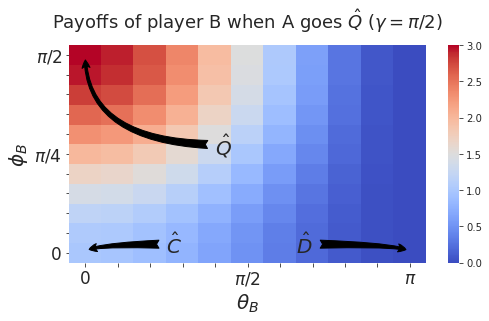

In [18]:
# Plot the results as a heatmap
fig = plt.figure(figsize=(8,4))

grid_me_AQ_pivot = grid_me_AQ.pivot("phiB", "thetaB", "utilityB")
minu_BvsQ = sns.heatmap(grid_me_AQ_pivot, cmap="coolwarm")

xticklabels = ['0'] + ['']*(len(thetaA)//2-1) + [r'$\pi$/2'] + ['']*(len(thetaA)//2-1) + [r'$\pi$']
yticklabels = ['0'] + ['']*(len(phiA)//2-1) + [r'$\pi$/4'] + ['']*(len(phiA)//2-1) + [r'$\pi/2$']

minu_BvsQ.set_xticklabels(xticklabels, size = 17, rotation=0)
minu_BvsQ.set_yticklabels(yticklabels, size = 17)
minu_BvsQ.set_title(r'Payoffs of player B when A goes $\hat{Q}$ ($\gamma=\pi/2$)', fontsize=18, y=1.05)
minu_BvsQ.set_xlabel(r'$\theta_B$', fontsize=20)
minu_BvsQ.set_ylabel(r'$\phi_B$', fontsize=20)

minu_BvsQ.annotate(r'$\hat{C}$', xy=(0.5,0.5), fontsize=20, xytext=(3,0.5),
                  arrowprops=dict(arrowstyle="fancy", color="0", shrinkA=5, shrinkB=5,
                                 connectionstyle="angle3,angleA=0,angleB=90"))
minu_BvsQ.annotate(r'$\hat{D}$', xy=(10.5,0.5), fontsize=20, xytext=(7,0.5),
                  arrowprops=dict(arrowstyle="fancy", color="0", shrinkA=5, shrinkB=5,
                                 connectionstyle="angle3,angleA=0,angleB=90"))
minu_BvsQ.annotate(r'$\hat{Q}$', xy=(0.5,10.5), fontsize=20, xytext=(4.5,5.5),
                  arrowprops=dict(arrowstyle="fancy", color="0", shrinkA=5, shrinkB=5,
                                 connectionstyle="angle3,angleA=0,angleB=90"))

minu_BvsQ.invert_yaxis()

In [19]:
PrisonersDilemma_gmax.Is_Pareto_Optimal(1220)

The strategy is Pareto optimal!


Very important result: the (unique) NE is also Pareto optimal! In the classical game, instead, the NE was not. <br>
In a certain sense, in the quantum framework, the "dilemma" has been solved.

### Quantum player vs Classical opponent

Now suppose that only player A is allowed to select quantum strategies, while player B is limited to the classical world:
* A's strategies: $\hat{U}(\theta_A,\phi_A)$
* B's strategies: $\hat{U}(\theta_B,0)$

Does this situation provide any kind of advantage to one of the players?

Again, let's study the NE in the maximum entangled case.

In [20]:
PrisonersDilemma_gmax_QC = Quantum2x2Game(payoff_matrix=payoff_matrix_pd, gamma=np.pi/2)
PrisonersDilemma_gmax_QC.update_parameters(phi=[0], player="B")

In [21]:
NE_pd_me_qc = PrisonersDilemma_gmax_QC.compute_Nash_Equilibrium()

Constructing the complete grid of payoffs...


  0%|          | 0/1331 [00:00<?, ?it/s]

Computing the best responses for the players...


  0%|          | 0/1331 [00:00<?, ?it/s]

In [22]:
display(NE_pd_me_qc)

,thetaA,phiA,thetaB,phiB,utilityA,utilityB,Best_responses_A,Best_responses_B


There are no NE in this game, and the reason is that player A is in a strong position respect to player B. It possible to prove, in fact, that there exists a strategy $\hat{M}$ avaiable to A (a "miracle move") that guarantees to him always the maximum payoff:
$$ \hat{M}\equiv\hat{U}(\pi/2,\pi/2)=\frac{1}{\sqrt{2}}\begin{pmatrix} i&-1\\1&-i \end{pmatrix}  $$
To prove it, we can directly look at the utility functions in that case.

In [23]:
PrisonersDilemma_gmax_QC_MM = Quantum2x2Game(payoff_matrix=payoff_matrix_pd, gamma=np.pi/2)
PrisonersDilemma_gmax_QC_MM.update_parameters(theta=[np.pi/2], phi=[np.pi/2], player="A")
PrisonersDilemma_gmax_QC_MM.update_parameters(theta=None, phi=[0], player="B")

In [24]:
payoffs_QvsC_MM = PrisonersDilemma_gmax_QC_MM.compute_payoff_grid()
payoffs_QvsC_MM

  0%|          | 0/11 [00:00<?, ?it/s]

,thetaA,phiA,thetaB,phiB,utilityA,utilityB
0,1.570796,1.570796,0.000000,0.0,3.000000,0.500000
1,1.570796,1.570796,0.314159,0.0,3.618034,0.345492
2,1.570796,1.570796,0.628319,0.0,4.175571,0.206107
3,1.570796,1.570796,0.942478,0.0,4.618034,0.095492
4,1.570796,1.570796,1.256637,0.0,4.902113,0.024472
...,...,...,...,...,...,...
6,1.570796,1.570796,1.884956,0.0,4.902113,0.024472
7,1.570796,1.570796,2.199115,0.0,4.618034,0.095492
8,1.570796,1.570796,2.513274,0.0,4.175571,0.206107
9,1.570796,1.570796,2.827433,0.0,3.618034,0.345492


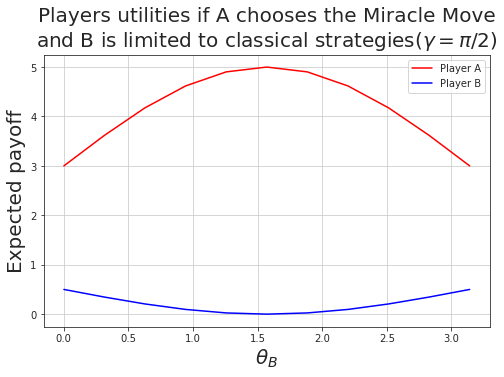

In [25]:
fig = plt.figure(figsize=(8,5))

plt.title("Players utilities if A chooses the Miracle Move\nand B is limited to classical strategies" 
          + r'($\gamma=\pi/2$)', fontsize=20, y=1.01)
plt.xlabel(r'$\theta_B$', fontsize=20)
plt.ylabel("Expected payoff", fontsize=20)
plt.plot(payoffs_QvsC_MM["thetaB"], payoffs_QvsC_MM["utilityA"], color="red", label="Player A")
plt.plot(payoffs_QvsC_MM["thetaB"], payoffs_QvsC_MM["utilityB"], color="blue", label="Player B")
plt.grid()
plt.legend();

Finally, we can make a comparison between the three "particular" strategies that A can select ($\hat{C}$, $\hat{D}$ or $\hat{M}$), as a function of the classical one chosen by the opponent.

In [26]:
PrisonersDilemma_gmax_AC = Quantum2x2Game(payoff_matrix=payoff_matrix_pd, gamma=np.pi/2)
PrisonersDilemma_gmax_AC.update_parameters(theta=[0], phi=[0], player="A")
PrisonersDilemma_gmax_AC.update_parameters(phi=[0], player="B")
util_AC = PrisonersDilemma_gmax_AC.compute_payoff_grid()["utilityA"]

PrisonersDilemma_gmax_AD = Quantum2x2Game(payoff_matrix=payoff_matrix_pd, gamma=np.pi/2)
PrisonersDilemma_gmax_AD.update_parameters(theta=[np.pi], phi=[0], player="A")
PrisonersDilemma_gmax_AD.update_parameters(phi=[0], player="B")
util_AD = PrisonersDilemma_gmax_AD.compute_payoff_grid()["utilityA"]

PrisonersDilemma_gmax_AM = Quantum2x2Game(payoff_matrix=payoff_matrix_pd, gamma=np.pi/2)
PrisonersDilemma_gmax_AM.update_parameters(theta=[np.pi/2], phi=[np.pi/2], player="A")
PrisonersDilemma_gmax_AM.update_parameters(phi=[0], player="B")
util_AM = PrisonersDilemma_gmax_AM.compute_payoff_grid()["utilityA"]

thetaB_values = PrisonersDilemma_gmax_AC.thetaB

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

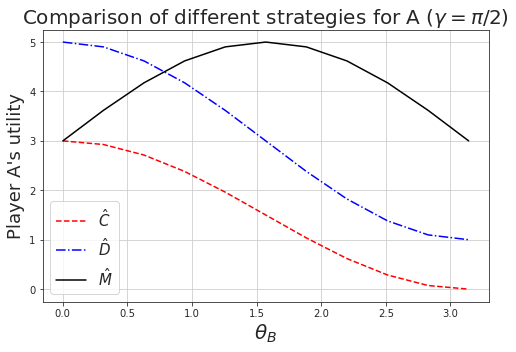

In [27]:
fig = plt.figure(figsize=(8,5))
plt.title(r'Comparison of different strategies for A ($\gamma=\pi/2$)', fontsize=20)
plt.xlabel(r'$\theta_B$', fontsize=20)
plt.ylabel("Player A's utility", fontsize=18)

plt.plot(thetaB_values, util_AC, label=r'$\hat{C}$', color="red", linestyle="dashed")
plt.plot(thetaB_values, util_AD, label=r'$\hat{D}$', color="blue", linestyle="dashdot")
plt.plot(thetaB_values, util_AM, label=r'$\hat{M}$', color="black", linestyle="solid")
plt.grid()
plt.legend(fontsize=15);

#### Payoffs at intermediate entaglement degrees

One last interesting analysis that can be done is looking at what happen when $\gamma$ goes from $0$ to $\pi$.

Let's evaluate

In [28]:
# First, make the grid thinner
thinner_step = np.pi/20
gamma_values = np.arange(0, np.pi/2*1.1, np.pi/100)
maximin_A = []

for g in gamma_values:
    PrisonersDilemma_gamma = Quantum2x2Game(payoff_matrix=payoff_matrix_pd, gamma=g, grid_step=thinner_step)
    PrisonersDilemma_gamma.update_parameters(phi=[0], player="B")
    maximin_A.append( PrisonersDilemma_gamma.compute_guaranteed_payoffs("A").max()["utility"] )

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/9261 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

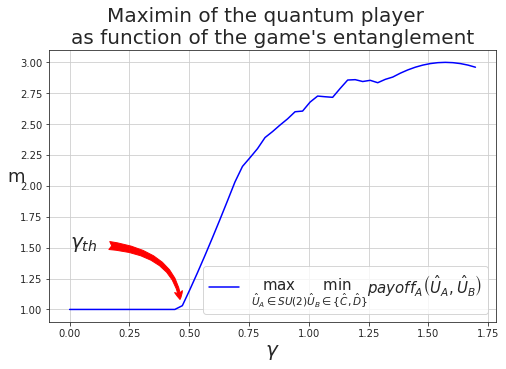

In [29]:
fig = plt.figure(figsize=(8,5))
plt.suptitle("Maximin of the quantum player", fontsize=20, y=1)
plt.title("as function of the game's entanglement", fontsize=20)
plt.xlabel(r'$\gamma$', fontsize=20)
plt.ylabel("m", fontsize=18, rotation=0)

plt.plot(gamma_values, maximin_A, 
         label=r'$\max_{\hat{U}_A\in SU(2)}\min_{\hat{U}_B\in\{\hat{C},\hat{D}\}} payoff_A\left(\hat{U}_A, \hat{U}_B\right)$', 
         color="blue")

plt.gca().annotate(r'$\gamma_{th}$', xy=(0.464,1), fontsize=20, xytext=(0,1.5),
                  arrowprops=dict(arrowstyle="fancy", color="red", shrinkA=10, shrinkB=10,
                                 connectionstyle="angle3,angleA=0,angleB=90"))

plt.grid()
plt.legend(fontsize=15);

# Quantum Battle of Sexes

The situation is quite similar to the Prisoners' Dilemma; we just need to specify a new payoff matrix.

$$
\text{Battle of Sexes Payoffs} = \begin{pmatrix}\alpha,\beta & \gamma,\gamma\\ \gamma,\gamma & \beta,\alpha\end{pmatrix}
$$
with the condition $\alpha\gt\beta\gt\gamma$.

In [30]:
# Specify the payoff matrix (with fixed values for alpha, beta and gamma)
payoff_matrix_bs = {'A' : np.array([[2,0],[0,1]]), 'B' : np.array([[1,0],[0,2]]) }

Actually, this time we have no more a strategy of "cooperation" and a strategy of "defection": we have just two people that want to choose different movies but, at the same time, they don't want to go alone. So the new set of pure strategies is $\{\hat{R},\hat{S}\}$, where "R" stands for the romance film, and $S$ for the sci-fi one.

Again, the first step is reformulating the pure strategies in term of quantum operators.

$$
\hat{R} = \hat{C} = \hat{U}(0,0) = \begin{pmatrix}1&0\\0&1\end{pmatrix} \qquad
\hat{S} = \hat{D} = \hat{U}(\pi,0) = \begin{pmatrix}0&1\\-1&0\end{pmatrix}
$$

* Study first the non entangled game: $\gamma=0$

In [31]:
# Construct the game
BattleOfSexes_g0 = Quantum2x2Game(payoff_matrix=payoff_matrix_bs, gamma=0)

In [32]:
NE_qbs_0 = BattleOfSexes_g0.compute_Nash_Equilibrium()
display(NE_qbs_0)

Constructing the complete grid of payoffs...


  0%|          | 0/14641 [00:00<?, ?it/s]

Computing the best responses for the players...


  0%|          | 0/14641 [00:00<?, ?it/s]

,thetaA,phiA,thetaB,phiB,utilityA,utilityB,Best_responses_A,Best_responses_B
0,0.000000,0.000000,0.000000,0.000000,2.0,1.0,True,True
1,0.000000,0.000000,0.000000,0.157080,2.0,1.0,True,True
2,0.000000,0.000000,0.000000,0.314159,2.0,1.0,True,True
3,0.000000,0.000000,0.000000,0.471239,2.0,1.0,True,True
4,0.000000,0.000000,0.000000,0.628319,2.0,1.0,True,True
...,...,...,...,...,...,...,...,...
14636,3.141593,1.570796,3.141593,0.942478,1.0,2.0,True,True
14637,3.141593,1.570796,3.141593,1.099557,1.0,2.0,True,True
14638,3.141593,1.570796,3.141593,1.256637,1.0,2.0,True,True
14639,3.141593,1.570796,3.141593,1.413717,1.0,2.0,True,True


Analyzing the dataframe, we clearly see that the only strategies that appear to be Nash Equilibria are of the type $\hat{U}(0,\phi)$, $\hat{U}(\pi,\phi)$, that correspond, as expected, to the classical pure strategies $\hat{R}$ and $\hat{S}$, respectively. <br>
So the NE of the non-entangled game are: $\{\hat{R}\hat{R}\}$ and $\{\hat{S}\hat{S}\}$. <br>
More precisely we have infinite equilibria: $\{\hat{U}_A(0,\phi),\hat{U}_B(0,\phi)\}$ and $\{\hat{U}_A(\pi,\phi),\hat{U}_B(\pi,\phi)\}$. 

* And now the maximally entangled case: $\gamma=\pi/2$

In [33]:
# Construct the game
BattleOfSexes_gmax = Quantum2x2Game(payoff_matrix=payoff_matrix_bs, gamma=np.pi/2)

In [34]:
NE_qbs_max = BattleOfSexes_gmax.compute_Nash_Equilibrium()
display(NE_qbs_max)

Constructing the complete grid of payoffs...


  0%|          | 0/14641 [00:00<?, ?it/s]

Computing the best responses for the players...


  0%|          | 0/14641 [00:00<?, ?it/s]

,thetaA,phiA,thetaB,phiB,utilityA,utilityB,Best_responses_A,Best_responses_B
13420,3.141593,0.000000,3.141593,0.000000,1.0,2.0,True,True
13421,3.141593,0.000000,3.141593,0.157080,1.0,2.0,True,True
13422,3.141593,0.000000,3.141593,0.314159,1.0,2.0,True,True
13423,3.141593,0.000000,3.141593,0.471239,1.0,2.0,True,True
13424,3.141593,0.000000,3.141593,0.628319,1.0,2.0,True,True
...,...,...,...,...,...,...,...,...
14636,3.141593,1.570796,3.141593,0.942478,1.0,2.0,True,True
14637,3.141593,1.570796,3.141593,1.099557,1.0,2.0,True,True
14638,3.141593,1.570796,3.141593,1.256637,1.0,2.0,True,True
14639,3.141593,1.570796,3.141593,1.413717,1.0,2.0,True,True


Incredible! From 2 pure strategy Nash Equilibria we end with just 1! <br>
Apparently, the only NE that survive the entanglement is the one in which both players select the strategy $\hat{U}(\pi,\phi)$, that basically coincide with playing $\{\hat{S}\hat{S}\}$!

In reality the situation is much more tricky than the one represented, becuase the battle of sexes is characterized by several more NE, in both pure and mixed strategies, that have been found analyzing the problem analitically. The fact is that, consulting several papers on the internet, several quantization models have been proposed, discussed and some of them also been contested, one end up with different, often also in contrast results. Up to now I wasn't able to find a "definitive" model, universally accepted, to quantize the Battle of Sexes, mainly because of its "internal asymmetry", that is also the feature that makes the problem so relevant.

To conclude, we can be quite satisfied of the simulation done, especially for the part of the Prisoners' Dilemma, since all the results were consistent with the theoretical analysis and provided a further confirmation of them. <br>
It has been very interesting to study game theory also from this new unusual point of view, especially because of the very large flexibility that quantum games provide, and I'm sure that, once the necessary technology will be publicy available, the interest to this discipline will explode once again. <br> 

Possible further improvements:
* completing the analysis of the Battle of Sexes
* improve the accuracy of the discretization
* implementation of an efficient way to handle mixed strategies